# Loop in computed FEFF Spectra / Determine which remain to be computed
## This is one of the most important steps.

## Goals: 
- Incorporate the already-computed FEFF spectra 
- Print which structures are still missing spectra
- Write X,Y pairs of Spectra-Properties (Coordination #, Bader Chg)

NOTE: There are a few points in this document where fine-tuning by eye has to be performed, including when pruning identical spectra, deciding what Bader charge difference is acceptable between different atoms of the same element, and when determining the cutoff minima or exclusion zones for the spectra. Please proceed with great caution through this notebook.

## Inputs: 
- {}\_{}\_MP\_OQMD\_combined_collations.json : The collatoins of all MP structures + spectra and OQMD structures (no spectra).
- feff\_prod\_image.json : Production image of FEFF spectra from Amazon AWS.

## Outputs: 
- {}\_{}\_XY.json : Json objects  decorated with relevant properties.

In [3]:
storage_directory = '/Users/steventorrisi/Documents/TRIXS/data/MP_OQMD_combined'
# Determine this by learning the MAE from another calculation.
bader_range_cutoff = .07

target_elements_groups=[('Co','O'),('Fe','O'),('V','O'),('Cu','O'),
                        ('Ni','O'),('Cr','O'),('Mn','O'),('Ti','O')]
target_metals = set(['Co','Ni','Fe','Cr','V','Mn','Cu','Ti'])
target_elements_sets =[set(pair) for pair in target_elements_groups]

## Import Statements

In [4]:
%load_ext autoreload
%autoreload 2
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from trixs.spectra.util import NumpyEncoder
from pymatgen.analysis.local_env import CrystalNN
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
import matplotlib.pyplot as plt
import json
import os
import gc as gc
import numpy as np
from pandas import DataFrame
from trixs.spectra.spectrum_compare import compare_spectrum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in the results of the previous pre-processing step
## in which MP and OQMD collated structures were computed

In [5]:
collations = {pair: [] for pair in target_elements_groups}
suffix = '_MP_OQMD_combined_collations.json'
collated_total = 0 
for pair in tqdm_notebook(target_elements_groups,desc='Loading in pairs'):
    target = storage_directory + '/{}_{}'.format(pair[0],pair[1])+ suffix
    with open(target,'r') as f:
        collations[pair] = [XAS_Collation.from_dict(json.loads(line)) for line in f.readlines()]
        collated_total += len(collations[pair])
cols_by_id = {pair: {} for pair in target_elements_groups}

ids_total = 0
for pair in target_elements_groups:
    for col in collations[pair]:
        if col.mp_id:
            cols_by_id[pair][col.mp_id] = col
        elif col.oqmd_id:
            cols_by_id[pair][col.oqmd_id] = col
        
    ids_total += len(cols_by_id[pair])

assert ids_total == collated_total 

/Users/steventorrisi/.local/lib/python3.6/site-packages/pymatgen/core/structure.py:638: UserWarning: Not all sites have property coordination_no. Missing values are set to None.
  "are set to None." % k)


# Load in computed spectra from Atomate

In [6]:
update_feff = False

if update_feff:
    ! scp -i /Users/steventorrisi/.ssh/steven-torrisi-materials.pem ${AWS_UBUNTU}:/home/ubuntu/feff_prod_image.json /Users/steventorrisi/Documents/TRIXS/data/feff_prod/.
    ! echo ${AWS_UBUNTU}

In [7]:
feff_spectra = []
with open('/Users/steventorrisi/Documents/TRIXS/data/feff_prod/feff_prod_image.json','r') as f:
    feff_spectra = [line for line in f.readlines() ]
print("Loaded in {} spectra".format(len(feff_spectra)))

Loaded in 10213 spectra


In [7]:
feff =' '
spectra_matched = {pair: 0 for pair in target_elements_groups}
for feff_line in tqdm_notebook(feff_spectra):
    del feff
    feff = json.loads(feff_line)
    #assert False
    absorbing_idx = feff['absorbing_atom']
    absorbing_elt = feff['structure']['sites'][absorbing_idx]['label']
    
    if absorbing_elt not in target_metals:
        continue
    
    run_id = feff['metadata']['id']
    mp_id = run_id if 'mp' in run_id else None
    oqmd_id = run_id if 'oqmd' in run_id else None
    
    present_pair = (absorbing_elt,'O')

    # Pick out the appropriate collation based on the MP id and/or the OQMD id.
    
    cur_col = cols_by_id[present_pair].get(mp_id,None)
    if cur_col is None:
        cur_col = cols_by_id[present_pair].get(oqmd_id,None)
    if not cur_col:
        continue
    
    # Check against double appenadage
    cur_col_ids = [spec['_id'] for spec in cur_col.feff_spectra if isinstance(spec,dict)]
    feff['metadata']={'origin': 'feff'}
    if feff['_id'] not in cur_col_ids:
        cur_col.feff_spectra.append(XAS_Spectrum.from_atomate_document(feff))   
        spectra_matched[present_pair]+=1

pprint(spectra_matched)



{('Co', 'O'): 261,
 ('Cr', 'O'): 629,
 ('Cu', 'O'): 398,
 ('Fe', 'O'): 1325,
 ('Mn', 'O'): 2853,
 ('Ni', 'O'): 403,
 ('Ti', 'O'): 2827,
 ('V', 'O'): 1425}


## Save all spectra-less structures

In [7]:
needs_spectra = {}
has_spectra = 0
for pair in tqdm_notebook(target_elements_groups): 
    for col in collations[pair]:
        if not col.has_spectra() and col.has_bader():
            if col.mp_id:
                needs_spectra[col.mp_id] = col.structure.as_dict()
            elif col.oqmd_id:
                needs_spectra[col.oqmd_id] = col.structure.as_dict()
        elif col.has_spectra():
            has_spectra +=1
                
with open(storage_directory+"/Needs_spectra_oxy.json",'w') as f: 
    for key, val in needs_spectra.items():
        f.write(json.dumps({key:val}) + '\n')
print("Wrote {} structures".format(len(needs_spectra)))


Wrote 11873 structures


### Now, we turn our attention to the structures for which we *do* have spectra

In [8]:
one_hot_coord_map = {
                4:(1,0,0),
                5:(0,1,0),
                6: (0,0,1)}

Determine minimum and maximum x values

The range of minima for ('Co', 'O'): [7710.667,7717.266]
The range of maxima for ('Co', 'O'): [7765.83,7772.428]


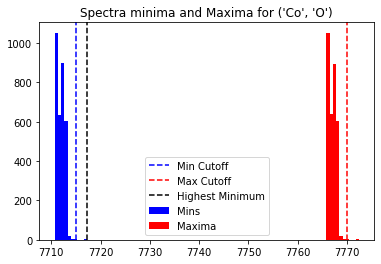

The range of minima for ('Fe', 'O'): [7112.602,7119.339]
The range of maxima for ('Fe', 'O'): [7167.764,7174.502]


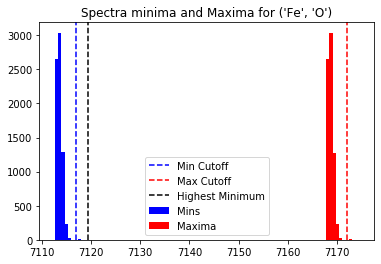

The range of minima for ('V', 'O'): [5465.469,5469.199]
The range of maxima for ('V', 'O'): [5520.631,5524.362]


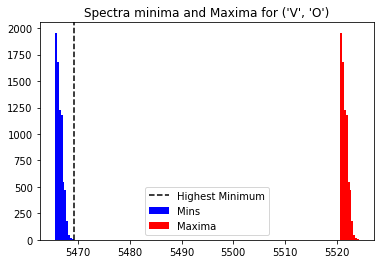

The range of minima for ('Cu', 'O'): [8984.566,8990.103]
The range of maxima for ('Cu', 'O'): [9039.728,9045.266]


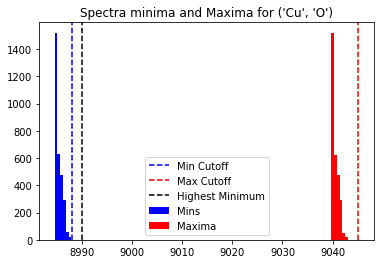

The range of minima for ('Ni', 'O'): [8333.561,8340.301]
The range of maxima for ('Ni', 'O'): [8388.723,8395.463]


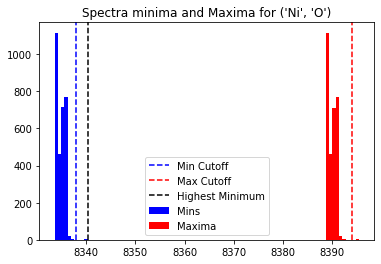

The range of minima for ('Cr', 'O'): [5990.523,5993.625]
The range of maxima for ('Cr', 'O'): [6045.686,6048.788]


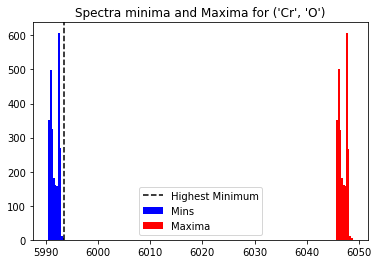

The range of minima for ('Mn', 'O'): [6539.255,6543.848]
The range of maxima for ('Mn', 'O'): [6594.417,6599.01]


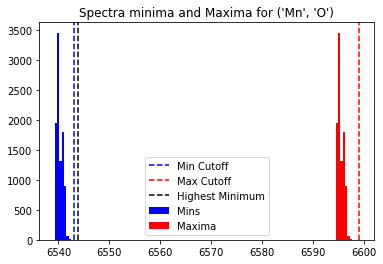

The range of minima for ('Ti', 'O'): [4965.862,4971.775]
The range of maxima for ('Ti', 'O'): [5021.024,5026.937]


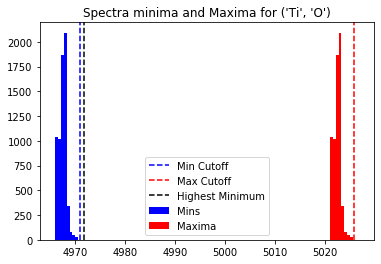

In [9]:
eyeballed_x_cutoffs = {('Co','O'):(7715,7770),
                       ('Fe','O'):(7117,7172),
                       ('Ni','O'):(8338,8394),
                       ('V','O'):None,
                       ('Mn','O'):(6543,6599),
                       ('Ti','O'):(4971,5026),
                       ('Cu','O'):(8988,9045),
                       ('Cr','O'):None}

limits_by_pair = {pair: () for pair in target_elements_groups}
domain_by_pair = {pair: () for pair in target_elements_groups}
for pair in tqdm_notebook(target_elements_groups): 
    mins = []
    maxs = []
    for col in [col for col in collations[pair] if col.has_spectra()]:
        for spec in col.mp_spectra + col.feff_spectra:
            spec = XAS_Spectrum.load_from_object(spec)
            mins.append(min(spec.x))
            maxs.append(max(spec.x))
            
    plt.hist(mins,color='blue',label='Mins')
    plt.hist(maxs,color='red',label='Maxima')
    plt.title("Spectra minima and Maxima for {}".format(pair))
    if eyeballed_x_cutoffs.get(pair,None):
        plt.axvline(eyeballed_x_cutoffs[pair][0],color='blue',ls='--',label='Min Cutoff')
        plt.axvline(eyeballed_x_cutoffs[pair][1],color='red',ls='--',label='Max Cutoff')
    plt.axvline(max(mins),color='black',ls='--',label='Highest Minimum')

    print('The range of minima for {}: [{},{}]'.format(pair,min(mins),max(mins)))
    print('The range of maxima for {}: [{},{}]'.format(pair,min(maxs),max(maxs)))
    plt.legend()
    plt.show()
    print('=========================')
    #domain_min = eyeballed_x_cutoffs.get(pair,None)
    #if not domain_min:
    domain_min = min(mins)
    #else:
    #    domain_min = domain_min[0]
    domain_by_pair[pair] = np.linspace(domain_min,min(maxs),100)

Define the "exclusion zone" of spectra with anomalously high peaks or anomalously fast falloff for statistical reasons

In [10]:
#Format: pair: [(x,y)]
lower_right_ez = {('Co','O'):[(7730,0.3)],
                           ('Fe','O'):[(7130,0.2)],
                           ('V','O'):[(5485,0.39)],
                            ('Cu','O'):[(9005,0.38),(9010,.39),(9020,.3),(9025,.35)],
                            ('Ni','O'):[(8347,0.05),(8355,.3)],
                            ('Cr','O'):[(6015,0.3)],
                            ('Mn','O'):[(6555,0.1),(6570,.15),(6590,.16)],
                            ('Ti','O'):[(4985,.3),(4980,.1)]}

upper_right_ez = {
                            ('Cu','O'):[(9025,.95)],
                            ('V','O'):[(5517,.9)]}
upper_left_ez = {}

def violates_exclusion_zone(exclz,pair,spec,region = 'lower_right'):
    zones = exclz.get(pair,None)
    if zones:
        for zone in zones:
            excl_x = zone[0]
            excl_y = zone[1]
            spec.normalize('max')
            if region=='lower_right':
                if any([(x >excl_x and y<excl_y) for x,y in zip(spec.x,spec.y)]): 
                    return True
            elif region=='upper_right':
                 if any([(x >excl_x and y>excl_y) for x,y in zip(spec.x,spec.y)]): 
                    return True
            elif region=='upper_left':
                return False
    
    return False


### Tally the final (X, Y) pairs, then loop through and prune duplicates

In [11]:
cnn = CrystalNN(distance_cutoffs = None)

excluded_spectra = {pair:[] for pair in target_elements_groups}
eyeballed_bader_cutoffs={pair:0 for pair in target_elements_groups}
eyeballed_bader_cutoffs[("Ti,O")] = .75
eyeballed_bader_cutoffs[("Mn,O")] = .5
eyeballed_bader_cutoffs[("Cr,O")] = .5
eyeballed_bader_cutoffs[("Co,O")] = .5

excluded_bader_spectra = {pair:[] for pair in target_elements_groups}



for pair in tqdm_notebook(target_elements_groups): 
    xy_target = storage_directory+'/{}_{}_XY.json'.format(pair[0],pair[1])
    all_spec_target = storage_directory+'/{}_{}_final_spectra.json'
    bader_counted = 0 
    spectra_counted = 0
    coords_counted = 0 
    excluded = 0 
    candidate_spectra = []
    candidate_data = []
    g = open(all_spec_target,'w')
    with open(xy_target,'w') as f:
        for col in tqdm_notebook([col for col in collations[pair]  if col.has_spectra()],
                                 desc=str(pair)):
            # Loop through the MP or FEFF spectra associated with a collation
            if col.has_mp_spectra():
                spectra = col.mp_spectra
            else:
                spectra = col.feff_spectra

            #Within said spectra, load into a spectrum,
            for spectrum in spectra:                
                spectrum = XAS_Spectrum.load_from_object(spectrum)
                
                # Check exclusion zones
                is_excluded = violates_exclusion_zone(lower_right_ez,pair,spectrum,'lower_right') or \
                              violates_exclusion_zone(upper_right_ez,pair,spectrum,'upper_right') or \
                              violates_exclusion_zone(upper_left_ez,pair,spectrum,'upper_left')
                
                if is_excluded:
                    excluded +=1
                    excluded_spectra[pair].append(spectrum)
                    continue
                abs_idx = spectrum.absorbing_site
                ID = str(abs_idx) + '-' + col.mp_id if col.mp_id else col.oqmd_id
                
                data = {}
                domain = domain_by_pair[pair]
                if spectrum.has_full_spectrum():
                    data['E'] = domain
                    data['mu'] = spectrum.project_to_x_range(domain)
                    data['E0'] = spectrum.Enorm
                    data['k'] = spectrum.k
                    data['mu0'] = spectrum.mu0
                    data['chi'] = spectrum.chi
                else:
                    data['E'] = domain
                    data['mu'] = spectrum.project_to_x_range(domain)
                    data['E0'] = np.array([])
                    data['k'] = np.array([])
                    data['mu0'] = np.array([])
                    data['chi'] = np.array([])
                    
                coord = spectrum.structure.sites[abs_idx].properties.get('coordination_no', None)
                if coord is None:
                    coord = cnn.get_cn(spectrum.structure,abs_idx)
                    
                if col.has_mp_bader() and col.has_oqmd_bader():
                    
                    relevant_mp_baders = [-1*chg[1] for chg in col.mp_bader if chg[0]==pair[0]]
                    relevant_oqmd_baders = [chg[1] for chg in col.oqmd_bader if chg[0]==pair[0]]
                    ##print(col.oqmd_bader)
                    #print(relevant_oqmd_baders)
                    mp_within_range = (np.max(relevant_mp_baders) - np.min(relevant_mp_baders)) <bader_range_cutoff
                    oqmd_within_range =  (np.max(relevant_oqmd_baders) - np.min(relevant_oqmd_baders)) <bader_range_cutoff
                    if mp_within_range and oqmd_within_range:
                        computed_bader = np.mean(relevant_mp_baders + relevant_oqmd_baders)
                        if computed_bader > eyeballed_bader_cutoffs[pair]:
                            data['bader']  = computed_bader
                elif col.has_bader():
                    if col.has_mp_bader():
                        relevant_baders = np.array([-1*chg[1] for chg in col.mp_bader if chg[0]==pair[0]])
                    else:
                        relevant_baders = np.array([chg[1] for chg in col.oqmd_bader if chg[0]==pair[0]])
                                                   
                    if (np.max(relevant_baders) - np.min(relevant_baders)) < bader_range_cutoff:
                        computed_bader = np.mean(relevant_baders)
                        if computed_bader > eyeballed_bader_cutoffs[pair]:
                            data['bader'] = computed_bader
                        else:
                            excluded_bader_spectra[pair].append(spectrum)
                        
                if not data.get('bader', False):
                    data['bader'] = None
                else:
                    bader_counted += 1
                    
                data ['coordination'] = coord
                data['one_hot_coord'] = one_hot_coord_map.get(coord,None)
                if data['one_hot_coord']:
                    coords_counted += 1
                data['metadata'] = spectrum.metadata
                spectra_counted += 1
                
                
                #Pick out spectra to write
                spectrum.normalize('max')
                candidate_spectra.append(spectrum)
                candidate_data.append(data)
                #f.write(json.dumps(data,cls=NumpyEncoder)+'\n')
                #g.write(json.dumps(spectrum.as_dict()) + '\n')
        #g.close() 
        duplicates_found = 0
        to_write = []
        unique_spectra = []
        print('Candidate spectra:',len(candidate_spectra))
        for i,cand in tqdm_notebook(enumerate(candidate_spectra),desc='Removing duplicates',
                                   total=len(candidate_spectra)):
            for uniq in unique_spectra:
                pass
                #if compare_spectrum(uniq,cand,method = 'euclidean')<.015:
                #    duplicates_found +=1
                #    continue
            unique_spectra.append(cand)
            to_write.append(candidate_data[i])
            
        
        for write in tqdm_notebook(to_write,desc='Writing'):
            f.write(json.dumps(write,cls=NumpyEncoder)+'\n')
        
    #for spectrum in unique_spectra:
    #    g.write(json.dumps(spectrum.as_dict()) + '\n')
    g.close() 

        
    print("Total spectra: {} , Total 4/5/6 coord: {} , Total Bader: {}, Excluded : {}, Redundant: {}".format(spectra_counted,coords_counted,bader_counted,excluded,duplicates_found))

Candidate spectra: 3174


Total spectra: 3174 , Total 4/5/6 coord: 3136 , Total Bader: 1803, Excluded : 34, Redundant: 0


Candidate spectra: 7064


Total spectra: 7064 , Total 4/5/6 coord: 6972 , Total Bader: 3743, Excluded : 178, Redundant: 0


Candidate spectra: 7076


Total spectra: 7076 , Total 4/5/6 coord: 7029 , Total Bader: 3834, Excluded : 220, Redundant: 0


Candidate spectra: 2879


Total spectra: 2879 , Total 4/5/6 coord: 2760 , Total Bader: 1588, Excluded : 105, Redundant: 0


Candidate spectra: 3068


Total spectra: 3068 , Total 4/5/6 coord: 3028 , Total Bader: 1870, Excluded : 16, Redundant: 0


Candidate spectra: 2534


Total spectra: 2534 , Total 4/5/6 coord: 2489 , Total Bader: 2022, Excluded : 32, Redundant: 0


Candidate spectra: 9421


Total spectra: 9421 , Total 4/5/6 coord: 9290 , Total Bader: 4828, Excluded : 57, Redundant: 0


Candidate spectra: 6345


Total spectra: 6345 , Total 4/5/6 coord: 6268 , Total Bader: 4145, Excluded : 132, Redundant: 0



##  TODO: Visualize information about the excluded spectra for future postmortem studying